---

### Sertac İnce 

Google Colab Free - T4 - Batch Size: 128

---

Importing libraries

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

import time

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


In [ ]:
plt.style.use('dark_background')

Device check

In [ ]:
# Changing the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

### Setting Up the Transforms

For the augmentation, I am using color jitter, random horizontal flip, auto 
augment. For more information: https://pytorch.org/vision/stable/transforms.html#color, 

https://pytorch.org/vision/stable/transforms.html#geometry

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((152,152)),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.AutoAugment(),
                                      transforms.ToTensor(),
                                      ])

In [ ]:
test_transforms = transforms.Compose([transforms.Resize((152,152)),
                                      transforms.ToTensor(),
                                    ])

### Setting Up Dataset

In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading the dataset

In [ ]:
import opendatasets as od
  
od.download(
    "https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sertacince
Your Kaggle Key: ··········


100%|██████████| 346M/346M [00:05<00:00, 68.8MB/s]


train test split


In [ ]:
train_dataset = datasets.ImageFolder('/content/intel-image-classification/seg_train/seg_train',transform=train_transforms)

In [ ]:
test_dataset = datasets.ImageFolder('/content/intel-image-classification/seg_test/seg_test',transform=test_transforms)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
from torch.utils.data import random_split

#### Train-Val Split

In [ ]:
val_size = int(len(train_dataset) * 0.2)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(11228, 2806)

### Data Loader Part

In [ ]:
batch_size = 128

# PyTorch data loaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)   
valid_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

---

## FUNCTIONS

---

Train, validate, and accuracy functions are copied and modified from LeNet5 file which is shown in last lecture

### Train Function

In [ ]:
def train(train_loader, model, criterion, optimizer, device):
    # Function for the training step of the training loop
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

### Validation, Accuracy and Test Functions

In [ ]:
def validate(valid_loader, model, criterion, device):
    # Function for the validation step of the training loop 
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [ ]:
def get_accuracy(model, data_loader, device):
    # Function for computing the accuracy of the predictions over the entire data_loader
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [ ]:
# Test Function
def test(model, test_data, criterion, device):
    _, test_loss = validate(test_data, model, criterion, device)
    test_acc = get_accuracy(model, test_data, device)

    print(f"\n{model.__class__.__name__} Test Loss: {test_loss}")
    print(f"{model.__class__.__name__} Test Accuracy: % {test_acc * 100}\n")

### Plot Functions

In [ ]:
def plot_losses(train_losses, valid_losses):
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    plt.plot(train_losses, color="red", label='Training loss') 
    plt.plot(valid_losses, color="cyan", label='Validation loss')
    plt.title("Loss over epochs") 
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.legend()
    plt.show()

In [ ]:
def plot_acc(train_acc, valid_acc):
    train_acc = np.array(train_acc) 
    valid_acc = np.array(valid_acc)

    plt.plot(train_acc, color="red", label='Training Accuracy') 
    plt.plot(valid_acc, color="cyan", label='Validation Accuracy')
    plt.title("Accuracy Over Epochs") 
    plt.xlabel("Epoch") 
    plt.ylabel("Accuracy") 
    plt.legend()
    plt.show()

### Main Training Loop

In [ ]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # Function defining the entire training loop    
    # set objects for storing metrics
    start_time = time.time()
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
 
    # Train model
    for epoch   in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # Accuracy values
        train_acc = get_accuracy(model, train_loader, device=device)
        train_accs.append(train_acc.cpu())
        valid_acc = get_accuracy(model, valid_loader, device=device)
        valid_accs.append(valid_acc.cpu())


        if epoch % print_every == (print_every - 1):
                
            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    print()
    print("--- %s seconds ---" % (time.time() - start_time))

    # Plot the loss and accuracies at the end of the each epoch
    plot_losses(train_losses, valid_losses)
    plot_acc(train_accs, valid_accs)
    
    return model, optimizer, (train_losses, valid_losses)

Below funciton is also copied from last last lecture and little customized 

In [ ]:
def showImgs(rowCount, colCount, X, trueLabels, estimatedLabels):
    fig, axes = plt.subplots(nrows=rowCount, ncols=colCount, figsize=(2*colCount, 2*rowCount))
    classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
    trueLabels_cpu = trueLabels.to('cpu').detach().numpy()
    estimatedLabels_cpu = estimatedLabels.to('cpu').detach().numpy()
    X_cpu = X.to('cpu').detach().numpy()
    for k in range(rowCount*colCount):
        true_label = trueLabels_cpu[k].item()
        estimated_label = estimatedLabels_cpu[k].item()

        ax = fig.add_subplot(colCount, rowCount, k+1)
        ax.imshow(X_cpu[k][0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('T: ' + str(classes[true_label]) + ',  P: ' + str(classes[estimated_label]), fontsize=9)

    plt.setp(axes, xticks=[], yticks=[])    
    fig.tight_layout()

---

# TESTING DIFFERENT NEURAL NETS

---

## Basic Neural Net -> 1 Convolutional Layer

This is dummy net with 1 convolutional layer and very less neurons.

In [ ]:
class BasicNet(nn.Module):

    def __init__(self, n_classes):
        super(BasicNet, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),       
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1,  padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*76*76, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
class_num = 6

model = BasicNet(class_num).to(device=device)

Summary

In [ ]:
summary(model, (3, 152, 152), device=device.type)
print()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 152, 152]             448
              ReLU-2         [-1, 16, 152, 152]               0
         MaxPool2d-3           [-1, 16, 76, 76]               0
            Linear-4                   [-1, 16]       1,478,672
              ReLU-5                   [-1, 16]               0
            Linear-6                    [-1, 6]             102
Total params: 1,479,222
Trainable params: 1,479,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.35
Params size (MB): 5.64
Estimated Total Size (MB): 12.25
----------------------------------------------------------------



### Training

Epoch: 0	Train loss: 1.8471	Valid loss: 1.7986	Train accuracy: 15.88	Valid accuracy: 14.54
Epoch: 1	Train loss: 1.7989	Valid loss: 1.7951	Train accuracy: 15.88	Valid accuracy: 14.54
Epoch: 2	Train loss: 1.7956	Valid loss: 1.7931	Train accuracy: 15.88	Valid accuracy: 14.54
Epoch: 3	Train loss: 1.7932	Valid loss: 1.7920	Train accuracy: 17.22	Valid accuracy: 16.75
Epoch: 4	Train loss: 1.7919	Valid loss: 1.7916	Train accuracy: 17.22	Valid accuracy: 16.75
Epoch: 5	Train loss: 1.7913	Valid loss: 1.7915	Train accuracy: 18.16	Valid accuracy: 16.86
Epoch: 6	Train loss: 1.7910	Valid loss: 1.7916	Train accuracy: 18.16	Valid accuracy: 16.86
Epoch: 7	Train loss: 1.7908	Valid loss: 1.7916	Train accuracy: 18.16	Valid accuracy: 16.86
Epoch: 8	Train loss: 1.7907	Valid loss: 1.7917	Train accuracy: 18.16	Valid accuracy: 16.86
Epoch: 9	Train loss: 1.7907	Valid loss: 1.7917	Train accuracy: 18.16	Valid accuracy: 16.86
Epoch: 10	Train loss: 1.7907	Valid loss: 1.7917	Train accuracy: 18.16	Valid accuracy: 16.8

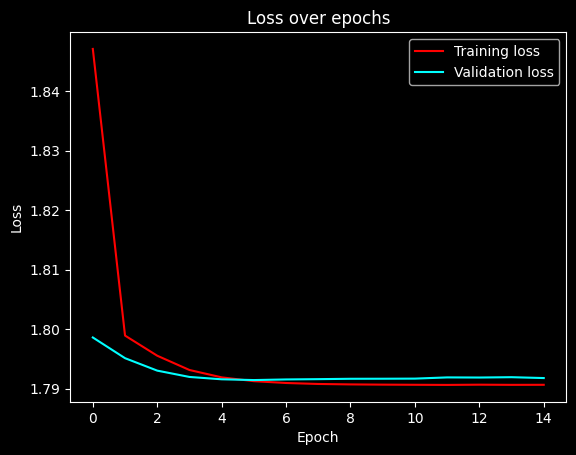

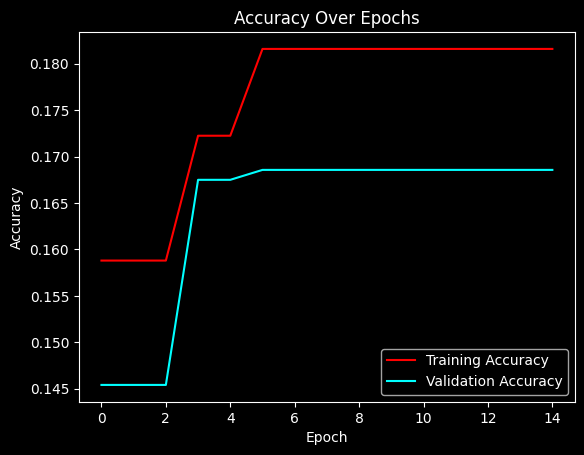

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

number_of_epochs = 15
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, number_of_epochs, device)

### Testing

In [ ]:
test(model, test_loader, criterion, device)


BasicNet Test Loss: 1.7904424931208294
BasicNet Test Accuracy: % 17.5



As we can see this dummy net cannot learn properly it needs more complex layers to learn.

In [ ]:
# Get the first test batch for visualizing

for idx, (data, targets) in enumerate(test_loader):
    X = data.to(device)
    trueLabels = targets;
    break

#### Visualizing the test results

In [ ]:
with torch.no_grad():
    y_hat, _ = model(X)

    maxProbabilities, estimatedLabels = torch.max(y_hat, axis=1)

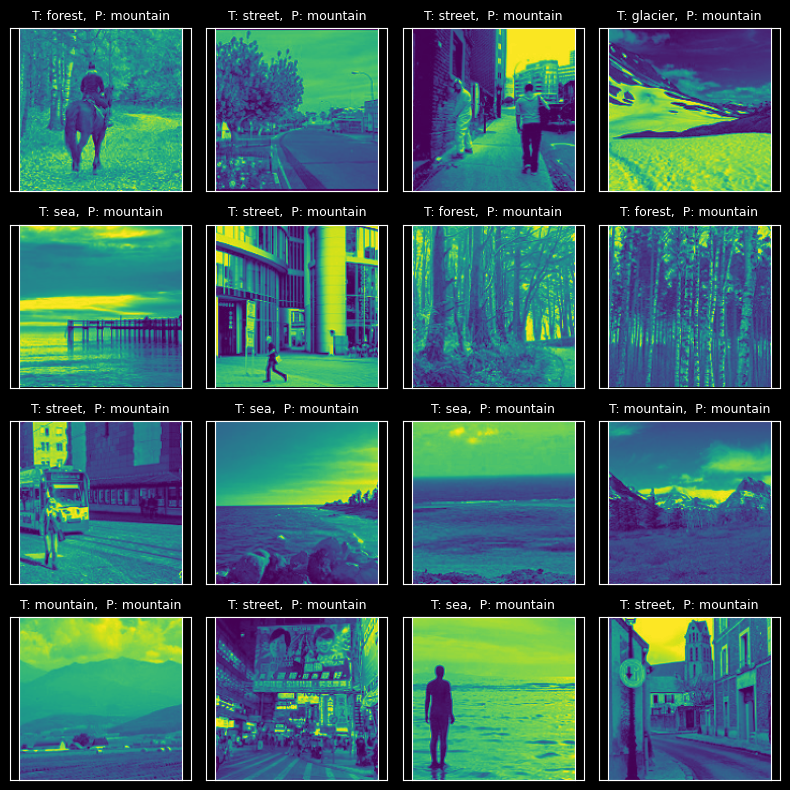

In [ ]:
rowCount = 4
colCount = 4

showImgs(rowCount, colCount, X, trueLabels, estimatedLabels)

### Confusion Matrix

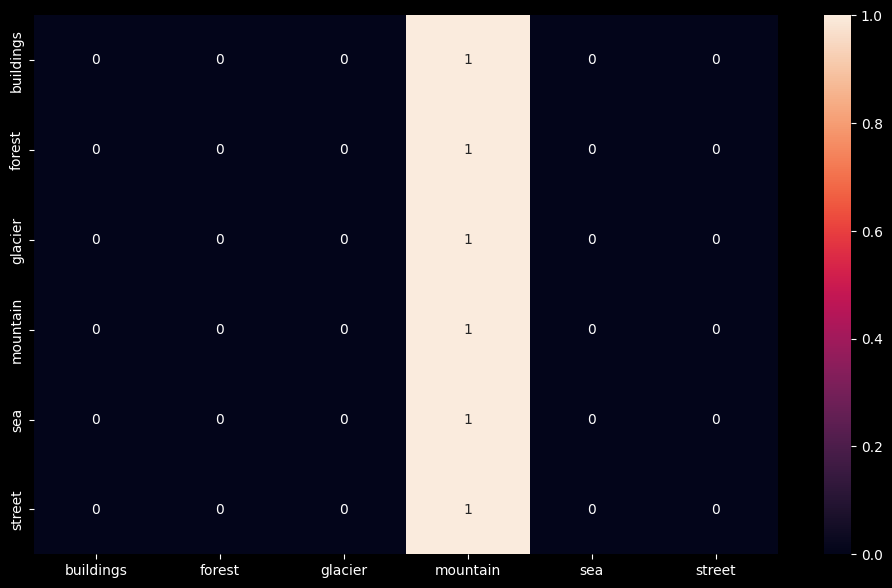

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea',
        'street')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output1.png')

There is nothing to say with this confusion matrix

---

## Basic Neural Net 2 -> 2 Conv layers

Here now I increased the number of convolutional layers and neurons in the hidden layer

In [ ]:
class BasicNet2(nn.Module):

    def __init__(self, n_classes):
        super(BasicNet2, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),       
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1,  padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*38*38, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
class_num = 6

model = BasicNet2(class_num).to(device=device)

Summary

In [ ]:
summary(model, (3, 152, 152), device=device.type)
print()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 152, 152]             448
              ReLU-2         [-1, 16, 152, 152]               0
         MaxPool2d-3           [-1, 16, 76, 76]               0
            Conv2d-4           [-1, 32, 76, 76]           4,640
              ReLU-5           [-1, 32, 76, 76]               0
         MaxPool2d-6           [-1, 32, 38, 38]               0
            Linear-7                  [-1, 100]       4,620,900
              ReLU-8                  [-1, 100]               0
            Linear-9                    [-1, 6]             606
Total params: 4,626,594
Trainable params: 4,626,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 9.52
Params size (MB): 17.65
Estimated Total Size (MB): 27.43
-------------------------------------

### Training

Epoch: 0	Train loss: 1.6222	Valid loss: 1.2746	Train accuracy: 49.71	Valid accuracy: 50.50
Epoch: 1	Train loss: 1.1851	Valid loss: 1.1449	Train accuracy: 56.25	Valid accuracy: 54.56
Epoch: 2	Train loss: 1.0336	Valid loss: 1.0060	Train accuracy: 62.20	Valid accuracy: 59.30
Epoch: 3	Train loss: 0.9636	Valid loss: 0.9396	Train accuracy: 64.51	Valid accuracy: 63.47
Epoch: 4	Train loss: 0.9216	Valid loss: 0.9967	Train accuracy: 64.43	Valid accuracy: 62.15
Epoch: 5	Train loss: 0.8653	Valid loss: 0.8623	Train accuracy: 69.75	Valid accuracy: 67.68
Epoch: 6	Train loss: 0.8288	Valid loss: 0.8632	Train accuracy: 70.78	Valid accuracy: 67.46
Epoch: 7	Train loss: 0.7971	Valid loss: 0.9198	Train accuracy: 68.87	Valid accuracy: 64.93
Epoch: 8	Train loss: 0.7932	Valid loss: 0.8774	Train accuracy: 71.18	Valid accuracy: 67.21
Epoch: 9	Train loss: 0.7648	Valid loss: 0.8233	Train accuracy: 74.71	Valid accuracy: 70.42
Epoch: 10	Train loss: 0.7359	Valid loss: 0.8538	Train accuracy: 72.84	Valid accuracy: 67.6

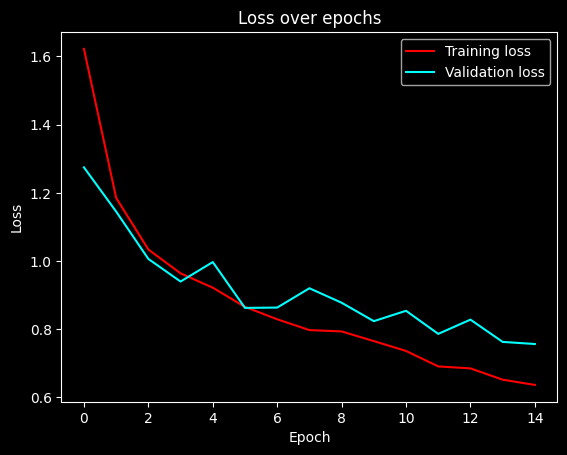

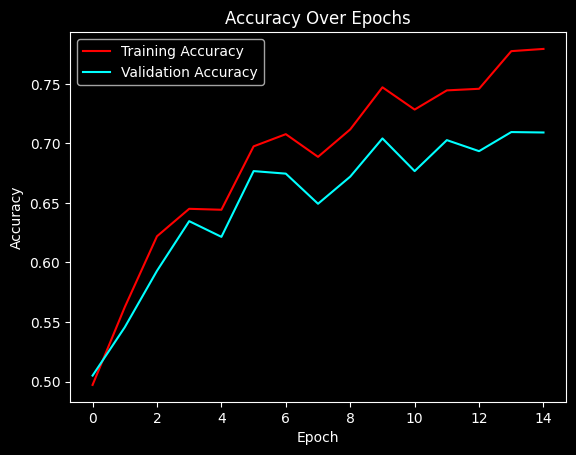

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

number_of_epochs = 15
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, number_of_epochs, device)

### Testing

In [ ]:
test(model, test_loader, criterion, device)


BasicNet2 Test Loss: 0.6353880376815796
BasicNet2 Test Accuracy: % 76.76666259765625



As we can see just adding one more convolutional layer and increasing number of neurons gets us very big difference.

But still we need to increase accuracy and decreases the loss

In [ ]:
## Visualizing the test results
for idx, (data, targets) in enumerate(test_loader):
    X = data.to(device)
    trueLabels = targets;
    break

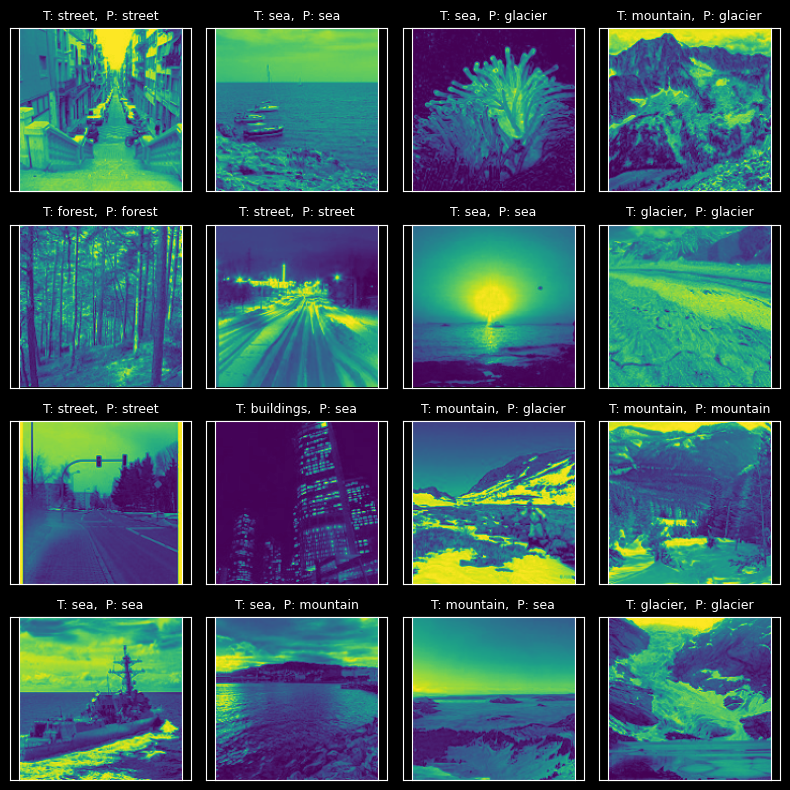

In [ ]:
with torch.no_grad():
    y_hat, _ = model(X)

    maxProbabilities, estimatedLabels = torch.max(y_hat, axis=1)

rowCount = 4
colCount = 4

showImgs(rowCount, colCount, X, trueLabels, estimatedLabels)    

### Confusion Matrix

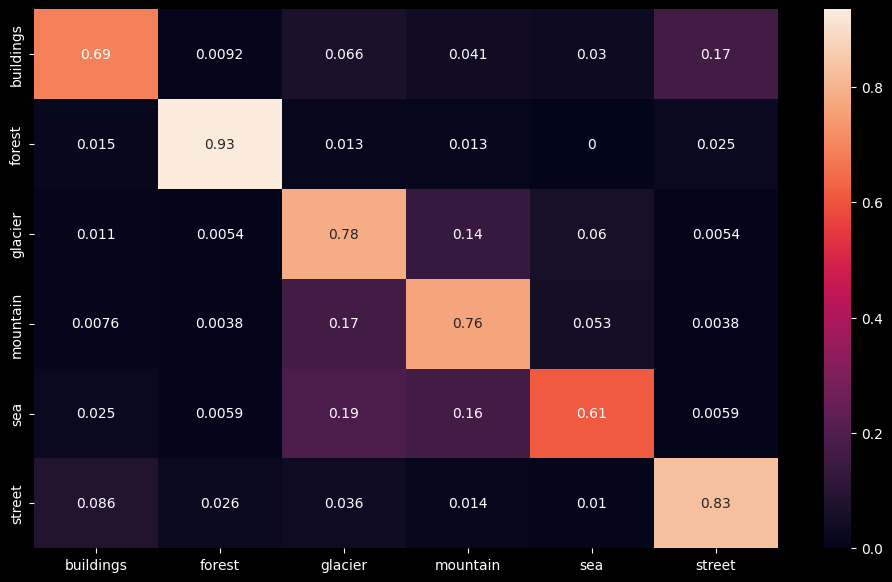

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea',
        'street')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output2.png')


As we can see glacier - mountain and glacier - sea and mountain sea and street - buildings are mixing.

---

### Neural Net 3 -> More Like Lenet5 

Here again I increased the convolutional layers and neurons. But now it looks like extended version of the improved lenet5 which is included in last lab.

In [ ]:
class Net3(nn.Module):

    def __init__(self, n_classes):
        super(Net3, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1),       
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=64*12*12, out_features=384),
            nn.ReLU(),
            nn.Linear(in_features=384, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
class_num = 6

model = Net3(class_num).to(device=device)

Summary

In [ ]:
summary(model, (3, 152, 152), device=device.type)
print()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 148, 148]           1,216
              ReLU-2         [-1, 16, 148, 148]               0
         MaxPool2d-3           [-1, 16, 74, 74]               0
            Conv2d-4           [-1, 32, 70, 70]          12,832
              ReLU-5           [-1, 32, 70, 70]               0
         MaxPool2d-6           [-1, 32, 35, 35]               0
            Conv2d-7           [-1, 48, 31, 31]          38,448
              ReLU-8           [-1, 48, 31, 31]               0
         MaxPool2d-9           [-1, 48, 16, 16]               0
           Conv2d-10           [-1, 64, 12, 12]          76,864
             ReLU-11           [-1, 64, 12, 12]               0
           Linear-12                  [-1, 384]       3,539,328
             ReLU-13                  [-1, 384]               0
           Linear-14                  [

### Training

Epoch: 0	Train loss: 1.5525	Valid loss: 1.4024	Train accuracy: 38.69	Valid accuracy: 36.56
Epoch: 1	Train loss: 1.2279	Valid loss: 1.0828	Train accuracy: 56.39	Valid accuracy: 56.20
Epoch: 2	Train loss: 1.0564	Valid loss: 0.9691	Train accuracy: 61.56	Valid accuracy: 61.55
Epoch: 3	Train loss: 1.0011	Valid loss: 0.9727	Train accuracy: 62.20	Valid accuracy: 60.51
Epoch: 4	Train loss: 0.9104	Valid loss: 0.8778	Train accuracy: 65.80	Valid accuracy: 64.22
Epoch: 5	Train loss: 0.8685	Valid loss: 0.8425	Train accuracy: 67.50	Valid accuracy: 65.29
Epoch: 6	Train loss: 0.8294	Valid loss: 0.8773	Train accuracy: 66.21	Valid accuracy: 64.93
Epoch: 7	Train loss: 0.7781	Valid loss: 0.7515	Train accuracy: 72.84	Valid accuracy: 71.95
Epoch: 8	Train loss: 0.7423	Valid loss: 0.8265	Train accuracy: 70.98	Valid accuracy: 69.14
Epoch: 9	Train loss: 0.7019	Valid loss: 0.7036	Train accuracy: 73.94	Valid accuracy: 73.24
Epoch: 10	Train loss: 0.6790	Valid loss: 0.7216	Train accuracy: 75.23	Valid accuracy: 72.8

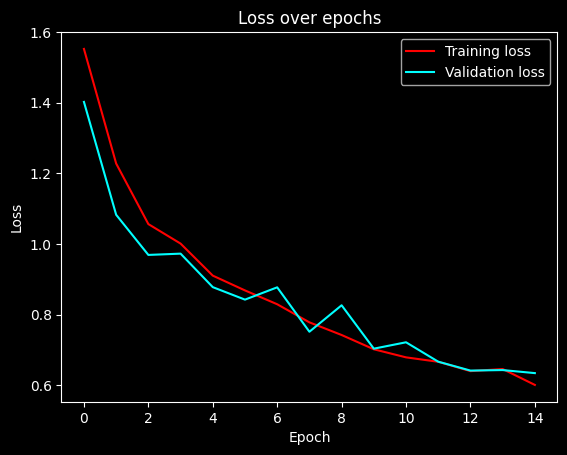

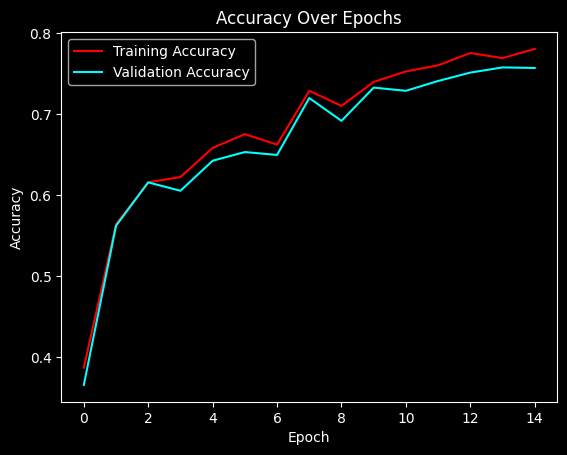

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

number_of_epochs = 15
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, number_of_epochs, device)

### Testing

In [ ]:
test(model, test_loader, criterion, device)


Net3 Test Loss: 0.5017818312644958
Net3 Test Accuracy: % 81.96666717529297



As we can see the performance is increased compared to previous net. And the loss is better.

#### Visualizing the test results

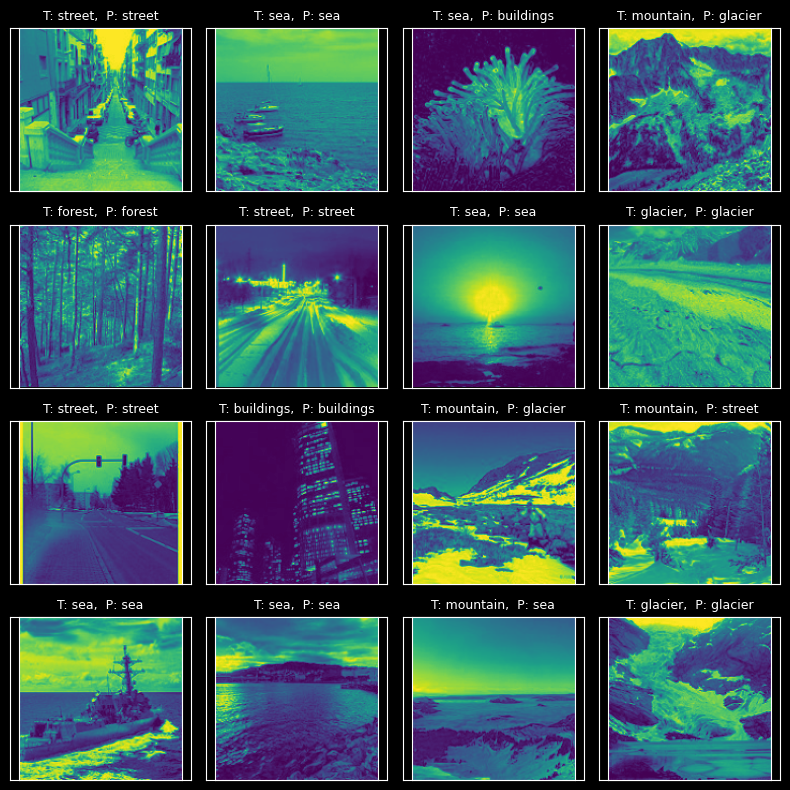

In [ ]:
with torch.no_grad():
    y_hat, _ = model(X)

    maxProbabilities, estimatedLabels = torch.max(y_hat, axis=1)

rowCount = 4
colCount = 4

showImgs(rowCount, colCount, X, trueLabels, estimatedLabels)    

### Confusion Matrix

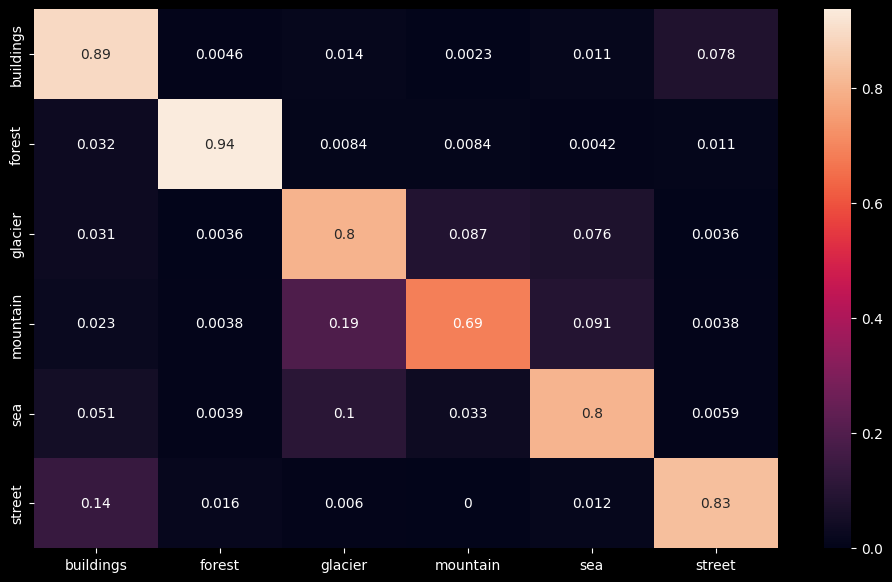

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea',
        'street')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output3.png')


As we can see, with the new model, misclassification of the mountain - sea is decreased.

---

### Neural Net 4 -> More Complex Neural Net

With this net, there are lots of convolutional layers, and also I am using batch normalization.

In [ ]:
class Net4(nn.Module):

    def __init__(self, n_classes):
        super(Net4, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1),       
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=2*2*128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=n_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
class_num = 6

model = Net4(class_num).to(device=device)

Summary

In [ ]:
summary(model, (3, 152, 152), device=device.type)
print()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
              ReLU-2         [-1, 16, 150, 150]               0
       BatchNorm2d-3         [-1, 16, 150, 150]              32
            Conv2d-4         [-1, 32, 148, 148]           4,640
              ReLU-5         [-1, 32, 148, 148]               0
         MaxPool2d-6           [-1, 32, 74, 74]               0
            Conv2d-7           [-1, 64, 72, 72]          18,496
              ReLU-8           [-1, 64, 72, 72]               0
       BatchNorm2d-9           [-1, 64, 72, 72]             128
           Conv2d-10           [-1, 96, 70, 70]          55,392
             ReLU-11           [-1, 96, 70, 70]               0
        MaxPool2d-12           [-1, 96, 35, 35]               0
           Conv2d-13          [-1, 128, 33, 33]         110,720
             ReLU-14          [-1, 128,

### Training

Epoch: 0	Train loss: 1.2473	Valid loss: 1.1276	Train accuracy: 56.76	Valid accuracy: 54.45
Epoch: 1	Train loss: 0.9351	Valid loss: 0.9062	Train accuracy: 65.19	Valid accuracy: 64.43
Epoch: 2	Train loss: 0.8034	Valid loss: 0.8848	Train accuracy: 65.75	Valid accuracy: 64.97
Epoch: 3	Train loss: 0.7231	Valid loss: 0.9037	Train accuracy: 65.47	Valid accuracy: 64.08
Epoch: 4	Train loss: 0.6865	Valid loss: 0.7211	Train accuracy: 73.57	Valid accuracy: 73.06
Epoch: 5	Train loss: 0.6393	Valid loss: 0.7990	Train accuracy: 70.90	Valid accuracy: 70.17
Epoch: 6	Train loss: 0.6028	Valid loss: 0.7827	Train accuracy: 69.43	Valid accuracy: 69.67
Epoch: 7	Train loss: 0.5802	Valid loss: 0.7399	Train accuracy: 73.83	Valid accuracy: 71.85
Epoch: 8	Train loss: 0.5589	Valid loss: 0.6752	Train accuracy: 73.90	Valid accuracy: 74.38
Epoch: 9	Train loss: 0.5186	Valid loss: 0.5658	Train accuracy: 79.93	Valid accuracy: 77.48
Epoch: 10	Train loss: 0.5048	Valid loss: 0.6322	Train accuracy: 78.19	Valid accuracy: 77.2

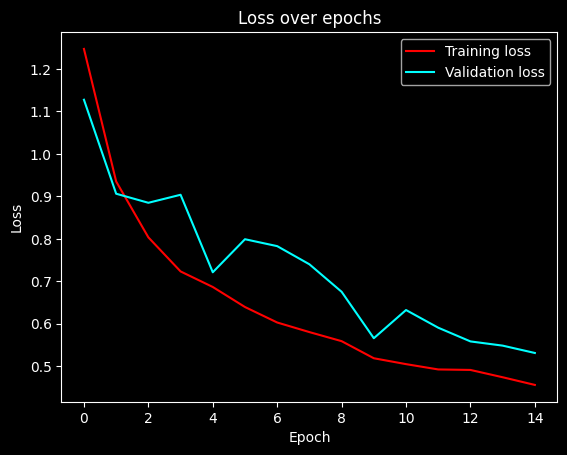

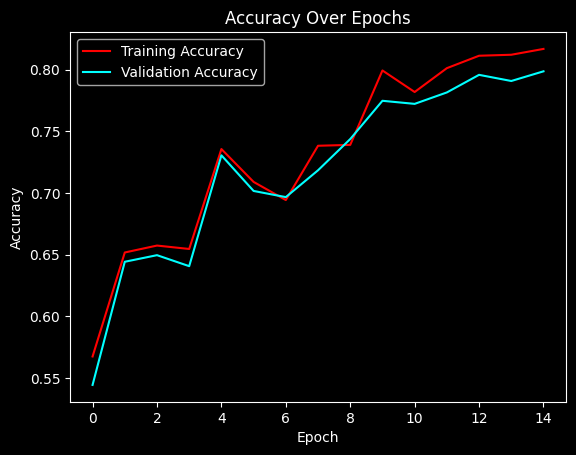

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

number_of_epochs = 15
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, number_of_epochs, device)

### Testing

In [ ]:
test(model, test_loader, criterion, device)


Net4 Test Loss: 0.4034037775993347
Net4 Test Accuracy: % 85.66667175292969



As we can see performance improved nicely, increasing tiers and using batch normalization made a big difference.

#### Visualizing the test results

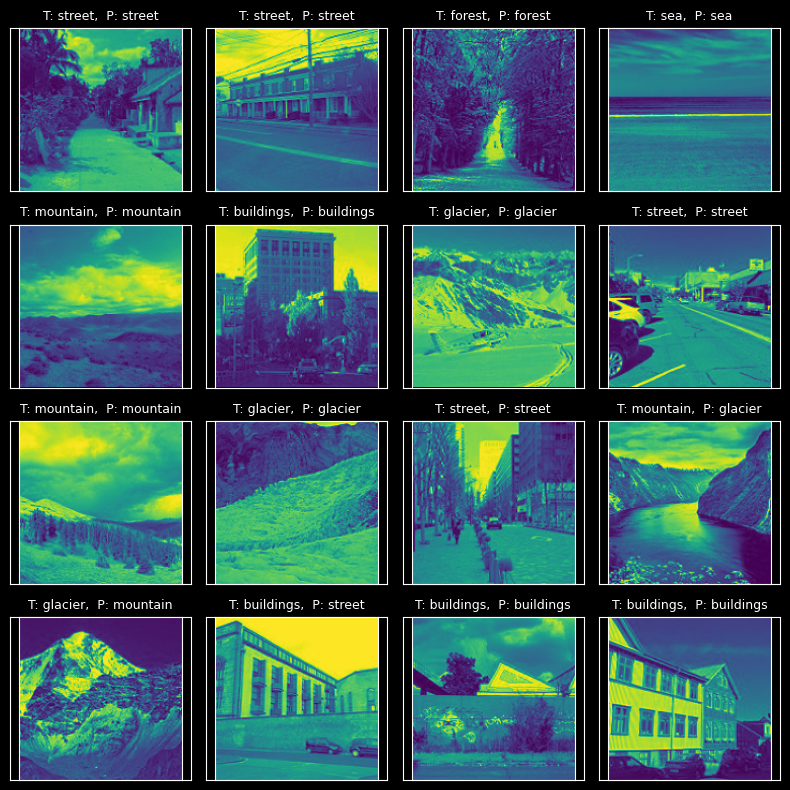

In [ ]:
with torch.no_grad():
    y_hat, _ = model(X)

    maxProbabilities, estimatedLabels = torch.max(y_hat, axis=1)

rowCount = 4
colCount = 4

showImgs(rowCount, colCount, X, trueLabels, estimatedLabels)    

## Confusion Matrix for decide which class is commonly misclassified

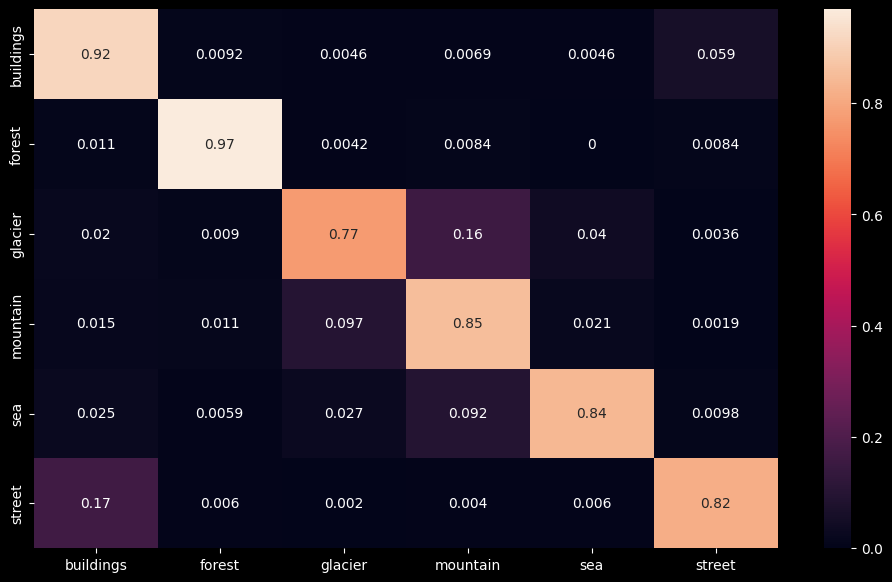

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea',
        'street')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output4.png')


There are still some problems with buildings - street and mountain glacier part. But general model's performance is good.

---

#### Up to this point I develop my own nets. But at the end I wanted to try with a ready net. 

---

## Training with Resnet50 - Without Weights

In this part I didn't use pretrained model weights. I am just using Resnet structure. Actually, this will show how do not using inital weights are bad for small datasets like now we are using with big nets like this net. Since we will do transfer learning in next homework, I am waiting for the next homework.

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x

        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        probs = F.softmax(x, dim=1)
        return x, probs
        
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
# Creating the net        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [ ]:
model = ResNet50(6, channels=3).to(device)

Summary

In [ ]:
summary(model, (3, 152, 152), device=device.type)
print()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 76, 76]           9,408
       BatchNorm2d-2           [-1, 64, 76, 76]             128
              ReLU-3           [-1, 64, 76, 76]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,160
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,928
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,640
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,640
      BatchNorm2d-14          [-1, 256,

### Training

Epoch: 0	Train loss: 1.3583	Valid loss: 1.1950	Train accuracy: 54.96	Valid accuracy: 54.56
Epoch: 1	Train loss: 0.9551	Valid loss: 1.6318	Train accuracy: 41.73	Valid accuracy: 41.77
Epoch: 2	Train loss: 0.8382	Valid loss: 1.5736	Train accuracy: 46.01	Valid accuracy: 45.62
Epoch: 3	Train loss: 0.7776	Valid loss: 3.2475	Train accuracy: 34.18	Valid accuracy: 34.96
Epoch: 4	Train loss: 0.7352	Valid loss: 0.7427	Train accuracy: 70.78	Valid accuracy: 70.81
Epoch: 5	Train loss: 0.6913	Valid loss: 0.8698	Train accuracy: 68.25	Valid accuracy: 67.96
Epoch: 6	Train loss: 0.8709	Valid loss: 2.0087	Train accuracy: 58.05	Valid accuracy: 58.09
Epoch: 7	Train loss: 0.7233	Valid loss: 0.9942	Train accuracy: 65.24	Valid accuracy: 64.86
Epoch: 8	Train loss: 0.6428	Valid loss: 0.7229	Train accuracy: 74.65	Valid accuracy: 72.95
Epoch: 9	Train loss: 0.6029	Valid loss: 0.6787	Train accuracy: 76.20	Valid accuracy: 74.41
Epoch: 10	Train loss: 0.5817	Valid loss: 1.6869	Train accuracy: 52.46	Valid accuracy: 51.6

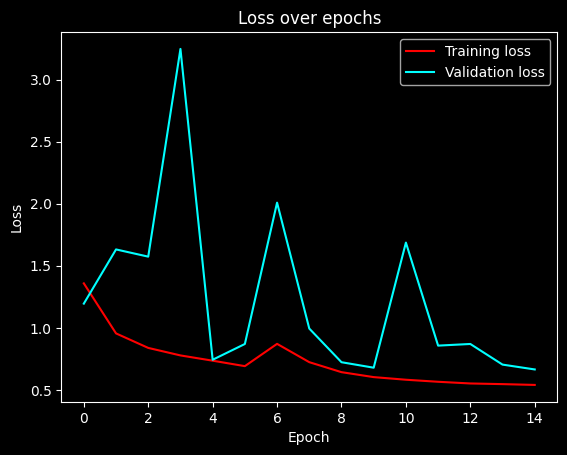

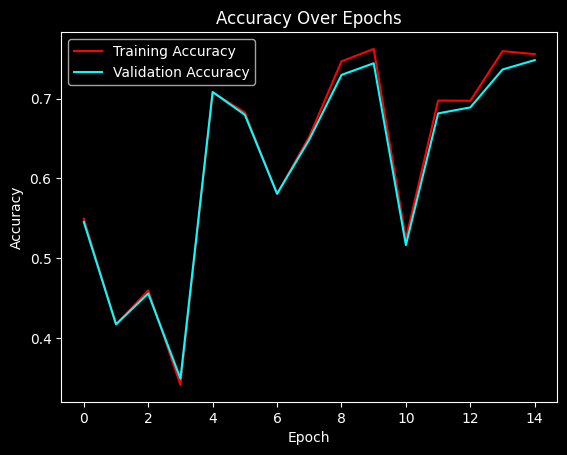

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

number_of_epochs = 15
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, number_of_epochs, device)

### Testing 

In [ ]:
test(model, test_loader, criterion, device)


ResNet Test Loss: 0.5418639172712962
ResNet Test Accuracy: % 80.06666564941406



Because of the net's complexity, we can see that the graphs become unstable. Although the overall score looks good, execution time of this net roughly 2 times slower then the previous one.

## Confusion Matrix

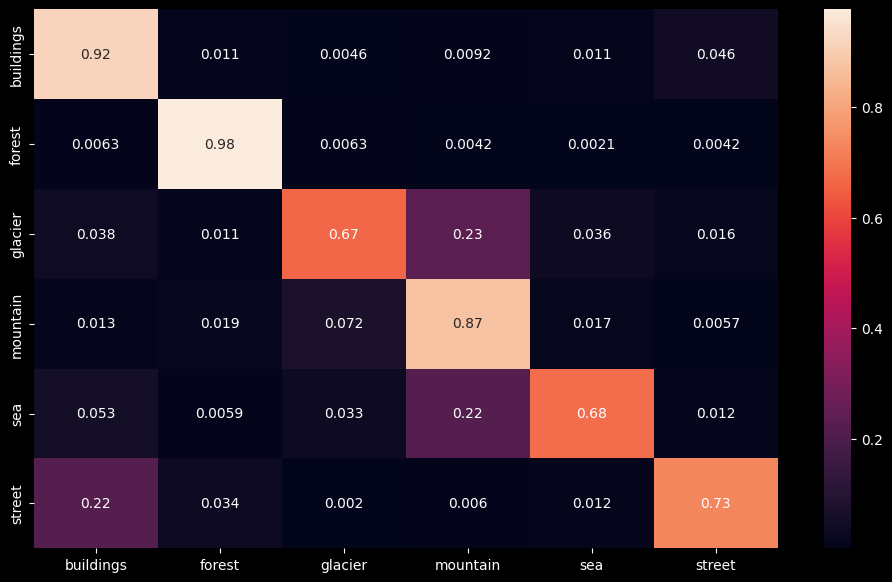

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea',
        'street')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output5.png')


Again there is a big problem with street - buildings and glacier - sea.

# RESULTS

---

## *Execution Times* - *Loss* - *Accuracy*

##### Basic Net             ---> 832.61 seconds ---> Test Loss: 1.79 ---> Test Accuracy: % 17.5

##### 2 Convolutional Net   ---> 800.26 seconds ---> Test Loss: 0.63 ---> Test Accuracy: % 76.76

##### More Like Lenet Net   ---> 799.32 seconds ---> Test Loss: 0.50 ---> Test Accuracy: % 81.96

##### Complex Net           ---> 929.12 seconds ---> Test Loss: 0.40 ---> Test Accuracy: % 85.66

##### ResNet50              ---> 1539.45 seconds ---> Test Loss: 0.54 ---> Test Accuracy: % 80.06


To sum up, as can be seen from the results, we see that Complex Net gives the best results. Basic Net gave an undeniably bad result because it contained only one convolutional layer. However, in general, it has been observed that adding a convolutional layer to a certain level improves performance. However, since nets with much more complexity such as resnet were created to train large datasets, some unstable results were revealed in the small dataset as we used. Therefore, much better results are expected if transfer learning was done on resnet.

#### Confusion Matrices

Apart from these, when looking at the confusion matrix, it has been observed that there are several very confused classes. Maybe applying different augmentations on these classes or increasing the data number of these classes can solve this result.

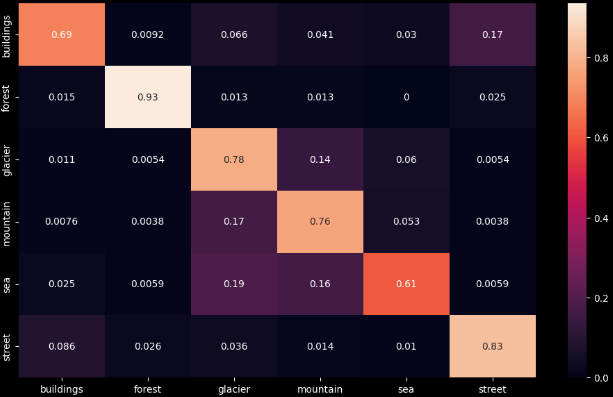
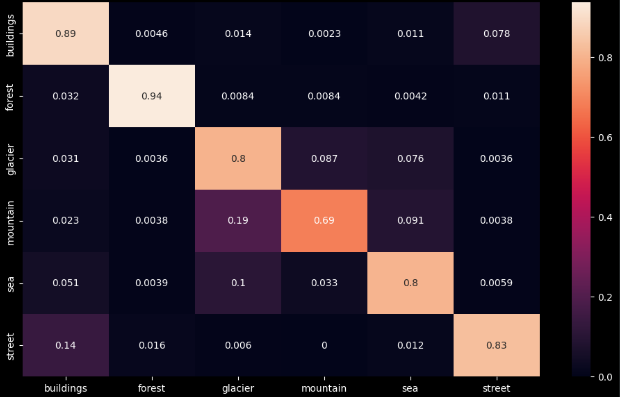
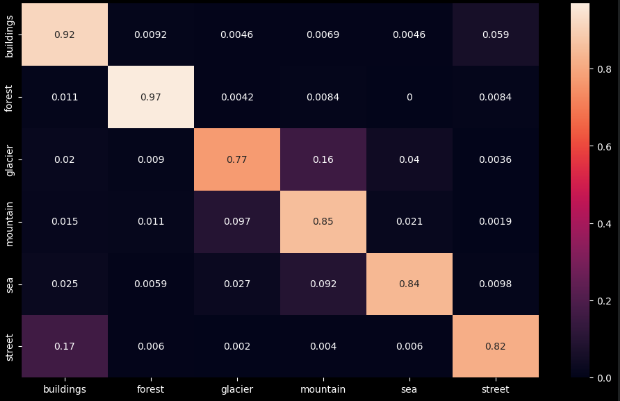
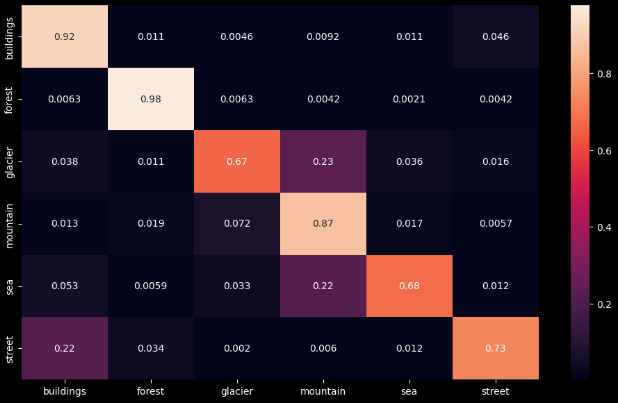